In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

# pd.set_option('display.float_format', lambda x: '%.20f' % x)

train_df = pd.read_csv('training_LSTM.csv') # historical data
test_df = pd.read_csv('testing_LSTM.csv') # predictions to be filled

In [2]:
train_df = train_df.fillna({'Province_State': 'Unknown'})
test_df = test_df.fillna({'Province_State': 'Unknown'})
train_df['Country_Region']= train_df['Country_Region'].str.replace("'", "")
train_df['Province_State']= train_df['Province_State'].str.replace("'", "")
test_df['Country_Region']= test_df['Country_Region'].str.replace("'", "")
test_df['Province_State']= test_df['Province_State'].str.replace("'", "")
print(train_df.isna().sum(),'\n')
print(test_df.isna().sum(),'\n')
print(train_df.dtypes, '\n')
print(test_df.dtypes, '\n')

Country_Region    0
Province_State    0
Date              0
ConfirmedCases    0
Recoveries        0
Fatalities        0
Id                0
dtype: int64 

Country_Region    0
Province_State    0
Date              0
ForecastId        0
dtype: int64 

Country_Region    object
Province_State    object
Date              object
ConfirmedCases     int64
Recoveries         int64
Fatalities         int64
Id                 int64
dtype: object 

Country_Region    object
Province_State    object
Date              object
ForecastId         int64
dtype: object 



In [3]:
def to_datetime(dt):
    return datetime.datetime.strptime(dt, '%Y-%m-%d')

def count_days(dt):
    return (dt - datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")).days

train_df['Date_dt'] = train_df['Date'].map(to_datetime)
train_df['Day'] = train_df['Date_dt'].map(count_days)
test_df['Date_dt'] = test_df['Date'].map(to_datetime)
test_df['Day'] = test_df['Date_dt'].map(count_days)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Min-Max Scaler
scaler_c = MinMaxScaler(feature_range=(0, 100))
train_df['ConfirmedCases_scaled'] = None
train_df[['ConfirmedCases_scaled']] = scaler_c.fit_transform(train_df[['ConfirmedCases']])

scaler_f = MinMaxScaler(feature_range=(0, 100))
train_df['Fatalities_scaled'] = None
train_df[['Fatalities_scaled']] = scaler_f.fit_transform(train_df[['Fatalities']])

# Get dummy columns for geo location
geo_columns = []
for i in range(294):
    geo_columns.append('Geo_{}'.format(i))
train_df.drop(columns=geo_columns, inplace=True, errors='ignore')

lbl_encoder = LabelEncoder()
scaler_g = MinMaxScaler(feature_range=(0, 1))
hot_encoder = OneHotEncoder(sparse=False)
train_df['Geo'] = train_df['Country_Region'].astype(str) + '_' + train_df['Province_State'].astype(str)
train_df[['Geo']] = lbl_encoder.fit_transform(train_df[['Geo']])
train_df = pd.get_dummies(train_df, prefix_sep="_", columns=['Geo'])

train_df.tail()    

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Country_Region,Province_State,Date,ConfirmedCases,Recoveries,Fatalities,Id,Date_dt,Day,ConfirmedCases_scaled,...,Geo_239,Geo_240,Geo_241,Geo_242,Geo_243,Geo_244,Geo_245,Geo_246,Geo_247,Geo_248
29377,Zimbabwe,Unknown,2020-05-14,37,13,4,29378,2020-05-14,113,0.002453,...,0,0,0,0,0,0,0,0,0,1
29378,Zimbabwe,Unknown,2020-05-15,42,13,4,29379,2020-05-15,114,0.002785,...,0,0,0,0,0,0,0,0,0,1
29379,Zimbabwe,Unknown,2020-05-16,42,13,4,29380,2020-05-16,115,0.002785,...,0,0,0,0,0,0,0,0,0,1
29380,Zimbabwe,Unknown,2020-05-17,44,17,4,29381,2020-05-17,116,0.002917,...,0,0,0,0,0,0,0,0,0,1
29381,Zimbabwe,Unknown,2020-05-18,46,18,4,29382,2020-05-18,117,0.003050,...,0,0,0,0,0,0,0,0,0,1


In [5]:
train_df['ConfirmedCases_scaled'].dtypes

dtype('float64')

In [6]:
historical_steps = 7
n_output_node = 1

def make_sequential_input(df):
    
    inputs_c, inputs_f, inputs_geo, targets_c, targets_f = [], [], [], [], []
    
    for i in range(len(df) - historical_steps - 1):
        
        if df.iloc[i]['Country_Region'] == df.iloc[i + historical_steps]['Country_Region'] and \
            df.iloc[i]['Province_State'] == df.iloc[i + historical_steps]['Province_State']:
            
            # iloc[a:b] startnig from index 'a' and ending before b
            inputs_c.append(np.array(df.iloc[i : i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # time seires until t-1
            inputs_f.append(np.array(df.iloc[i : i + historical_steps][['Fatalities_scaled']]).tolist()) # time seires until t-1
            inputs_geo.append(np.array(df.iloc[i + historical_steps][geo_columns]).tolist())
            targets_c.append(np.array(df.iloc[i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # result data at time t
            targets_f.append(np.array(df.iloc[i + historical_steps][['Fatalities_scaled']]).tolist()) # result data at time t
              
    return inputs_c, inputs_f, inputs_geo, targets_c, targets_f

# Make sequential input for training and validation
train_inputs, train_inputs_f, train_inputs_geo, train_targets_c, train_targets_f = make_sequential_input(train_df)

print('Train input shape: {}'.format(np.shape(train_inputs)))
print('Train input geo shape: {}'.format(np.shape(train_inputs_geo)))

D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Train input shape: (19757, 7, 1)
Train input geo shape: (19757, 294)


In [7]:
import random

max_index = np.array(train_inputs).shape[0] - 1
indices = []

for i in range(int(max_index*0.20)):
    indices.append(random.randint(0, max_index))

val_inputs = [ train_inputs[i] for i in indices ]
val_inputs_f = [ train_inputs_f[i] for i in indices ]
val_inputs_geo = [ train_inputs_geo[i] for i in indices  ] 
val_targets_c = [ train_targets_c[i] for i in indices ]
val_targets_f = [ train_targets_f[i] for i in indices ]

train_inputs = [ elem for i, elem in enumerate(train_inputs) if i not in indices ] 
train_inputs_f = [ elem for i, elem in enumerate(train_inputs_f) if i not in indices ] 
train_inputs_geo = [ elem for i, elem in enumerate(train_inputs_geo) if i not in indices ] 
train_targets_c = [ elem for i, elem in enumerate(train_targets_c) if i not in indices ] 
train_targets_f = [ elem for i, elem in enumerate(train_targets_f) if i not in indices ] 

pd.set_option('display.max_colwidth', -1)
print('No. train data: {}'.format(len(train_inputs)))
print('No. validation data: {}'.format(len(val_inputs)))

No. train data: 16163
No. validation data: 3951


Tarining model for ConfirmedCases
Train on 16163 samples, validate on 3951 samples
Epoch 1/200
16163/16163 [==============================] - 10s 646us/sample - loss: 0.0206 - mean_absolute_error: 0.2158 - mean_squared_error: 8.3325 - val_loss: 0.0123 - val_mean_absolute_error: 0.2263 - val_mean_squared_error: 14.1398
Epoch 2/200
16163/16163 [==============================] - 4s 231us/sample - loss: 0.0073 - mean_absolute_error: 0.1552 - mean_squared_error: 6.9151 - val_loss: 0.0093 - val_mean_absolute_error: 0.2010 - val_mean_squared_error: 13.2004
Epoch 3/200
16163/16163 [==============================] - 4s 252us/sample - loss: 0.0058 - mean_absolute_error: 0.1379 - mean_squared_error: 6.4961 - val_loss: 0.0079 - val_mean_absolute_error: 0.1881 - val_mean_squared_error: 12.6132
Epoch 4/200
16163/16163 [==============================] - 4s 227us/sample - loss: 0.0049 - mean_absolute_error: 0.1268 - mean_squared_error: 6.1480 - val_loss: 0.0070 - val_mean_absolute_error: 0.1838 - val_

16163/16163 [==============================] - 4s 238us/sample - loss: 3.7637e-04 - mean_absolute_error: 0.0491 - mean_squared_error: 1.1022 - val_loss: 6.8802e-04 - val_mean_absolute_error: 0.0918 - val_mean_squared_error: 3.2284
Epoch 36/200
16163/16163 [==============================] - 4s 266us/sample - loss: 3.7008e-04 - mean_absolute_error: 0.0485 - mean_squared_error: 1.0638 - val_loss: 6.0098e-04 - val_mean_absolute_error: 0.0808 - val_mean_squared_error: 3.0348
Epoch 37/200
16163/16163 [==============================] - 4s 245us/sample - loss: 3.4272e-04 - mean_absolute_error: 0.0465 - mean_squared_error: 0.9892 - val_loss: 5.5459e-04 - val_mean_absolute_error: 0.0778 - val_mean_squared_error: 2.8747
Epoch 38/200
16163/16163 [==============================] - 4s 244us/sample - loss: 3.1467e-04 - mean_absolute_error: 0.0447 - mean_squared_error: 0.8923 - val_loss: 5.2356e-04 - val_mean_absolute_error: 0.0771 - val_mean_squared_error: 2.7330
Epoch 39/200
16163/16163 [===========

Epoch 69/200
16163/16163 [==============================] - 4s 234us/sample - loss: 1.3880e-04 - mean_absolute_error: 0.0243 - mean_squared_error: 0.1318 - val_loss: 9.3681e-05 - val_mean_absolute_error: 0.0340 - val_mean_squared_error: 0.5693
Epoch 70/200
16163/16163 [==============================] - 4s 261us/sample - loss: 1.3780e-04 - mean_absolute_error: 0.0244 - mean_squared_error: 0.1512 - val_loss: 9.8844e-05 - val_mean_absolute_error: 0.0355 - val_mean_squared_error: 0.5508
Epoch 71/200
16163/16163 [==============================] - 4s 250us/sample - loss: 1.4619e-04 - mean_absolute_error: 0.0230 - mean_squared_error: 0.1103 - val_loss: 1.2266e-04 - val_mean_absolute_error: 0.0392 - val_mean_squared_error: 0.5321
Epoch 72/200
16163/16163 [==============================] - 5s 280us/sample - loss: 1.4534e-04 - mean_absolute_error: 0.0248 - mean_squared_error: 0.1359 - val_loss: 1.1277e-04 - val_mean_absolute_error: 0.0360 - val_mean_squared_error: 0.5000
Epoch 73/200
16163/16163

16163/16163 [==============================] - 4s 228us/sample - loss: 1.1663e-04 - mean_absolute_error: 0.0189 - mean_squared_error: 0.0418 - val_loss: 5.9212e-05 - val_mean_absolute_error: 0.0230 - val_mean_squared_error: 0.1249
Epoch 136/200
16163/16163 [==============================] - 4s 226us/sample - loss: 1.2591e-04 - mean_absolute_error: 0.0196 - mean_squared_error: 0.0462 - val_loss: 7.4507e-05 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.1211
Epoch 137/200
16163/16163 [==============================] - 4s 228us/sample - loss: 1.1918e-04 - mean_absolute_error: 0.0190 - mean_squared_error: 0.0515 - val_loss: 4.7665e-05 - val_mean_absolute_error: 0.0212 - val_mean_squared_error: 0.1157
Epoch 138/200
16163/16163 [==============================] - 4s 233us/sample - loss: 1.2394e-04 - mean_absolute_error: 0.0193 - mean_squared_error: 0.0487 - val_loss: 3.8948e-05 - val_mean_absolute_error: 0.0181 - val_mean_squared_error: 0.1108
Epoch 139/200
16163/16163 [=======

16163/16163 [==============================] - ETA: 0s - loss: 3.3183e-05 - mean_absolute_error: 0.0089 - mean_squared_error: 0.01 - 3s 206us/sample - loss: 3.2988e-05 - mean_absolute_error: 0.0089 - mean_squared_error: 0.0131
Model Accuracy: [3.29880262405706e-05, 0.0088766515, 0.013090233]


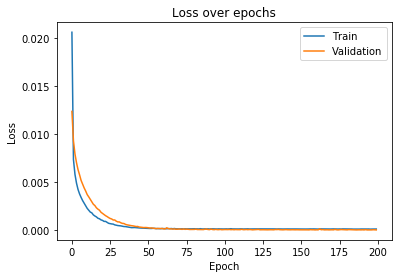

Tarining model for Fatalities
Train on 16163 samples, validate on 3951 samples
Epoch 1/200
16163/16163 [==============================] - 8s 504us/sample - loss: 0.0211 - mean_absolute_error: 0.2523 - mean_squared_error: 9.1942 - val_loss: 0.0140 - val_mean_absolute_error: 0.2563 - val_mean_squared_error: 14.5503
Epoch 2/200
16163/16163 [==============================] - 4s 227us/sample - loss: 0.0097 - mean_absolute_error: 0.2011 - mean_squared_error: 7.7269 - val_loss: 0.0099 - val_mean_absolute_error: 0.2318 - val_mean_squared_error: 13.3115ss: 0.0103 - mean_absolute_error: 0.2126 - mean_squared
Epoch 3/200
16163/16163 [==============================] - 4s 226us/sample - loss: 0.0071 - mean_absolute_error: 0.1826 - mean_squared_error: 6.8843 - val_loss: 0.0079 - val_mean_absolute_error: 0.2099 - val_mean_squared_error: 12.4364
Epoch 4/200
16163/16163 [==============================] - 4s 224us/sample - loss: 0.0054 - mean_absolute_error: 0.1630 - mean_squared_error: 6.2121 - val_los

Epoch 35/200
16163/16163 [==============================] - 4s 229us/sample - loss: 3.3994e-04 - mean_absolute_error: 0.0491 - mean_squared_error: 1.0549 - val_loss: 6.5884e-04 - val_mean_absolute_error: 0.0863 - val_mean_squared_error: 3.1779
Epoch 36/200
16163/16163 [==============================] - 4s 230us/sample - loss: 2.9445e-04 - mean_absolute_error: 0.0456 - mean_squared_error: 0.9487 - val_loss: 5.9801e-04 - val_mean_absolute_error: 0.0791 - val_mean_squared_error: 3.0099
Epoch 37/200
16163/16163 [==============================] - 4s 228us/sample - loss: 3.1264e-04 - mean_absolute_error: 0.0462 - mean_squared_error: 1.0046 - val_loss: 5.6879e-04 - val_mean_absolute_error: 0.0777 - val_mean_squared_error: 2.8637
Epoch 38/200
16163/16163 [==============================] - 4s 227us/sample - loss: 2.8518e-04 - mean_absolute_error: 0.0446 - mean_squared_error: 0.9120 - val_loss: 5.3574e-04 - val_mean_absolute_error: 0.0804 - val_mean_squared_error: 2.7368
Epoch 39/200
16163/16163

Epoch 102/200
16163/16163 [==============================] - 4s 223us/sample - loss: 1.0975e-04 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0753 - val_loss: 5.1716e-05 - val_mean_absolute_error: 0.0217 - val_mean_squared_error: 0.1793
Epoch 103/200
16163/16163 [==============================] - 4s 226us/sample - loss: 1.0367e-04 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0630 - val_loss: 5.5347e-05 - val_mean_absolute_error: 0.0201 - val_mean_squared_error: 0.1783
Epoch 104/200
16163/16163 [==============================] - 4s 227us/sample - loss: 9.6546e-05 - mean_absolute_error: 0.0199 - mean_squared_error: 0.0559 - val_loss: 5.3624e-05 - val_mean_absolute_error: 0.0214 - val_mean_squared_error: 0.1912
Epoch 105/200
16163/16163 [==============================] - 4s 230us/sample - loss: 1.0444e-04 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0731 - val_loss: 4.8124e-05 - val_mean_absolute_error: 0.0202 - val_mean_squared_error: 0.1672
Epoch 106/200
16163/

16163/16163 [==============================] - 4s 238us/sample - loss: 9.8890e-05 - mean_absolute_error: 0.0207 - mean_squared_error: 0.0514 - val_loss: 7.0499e-05 - val_mean_absolute_error: 0.0179 - val_mean_squared_error: 0.0693
Epoch 169/200
16163/16163 [==============================] - 4s 227us/sample - loss: 9.8873e-05 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0623 - val_loss: 7.5667e-05 - val_mean_absolute_error: 0.0228 - val_mean_squared_error: 0.0723
Epoch 170/200
16163/16163 [==============================] - 4s 231us/sample - loss: 9.2289e-05 - mean_absolute_error: 0.0179 - mean_squared_error: 0.0339 - val_loss: 3.6069e-05 - val_mean_absolute_error: 0.0136 - val_mean_squared_error: 0.0618
Epoch 171/200
16163/16163 [==============================] - 4s 239us/sample - loss: 1.0042e-04 - mean_absolute_error: 0.0204 - mean_squared_error: 0.0557 - val_loss: 3.7869e-05 - val_mean_absolute_error: 0.0158 - val_mean_squared_error: 0.0895
Epoch 172/200
16163/16163 [=======

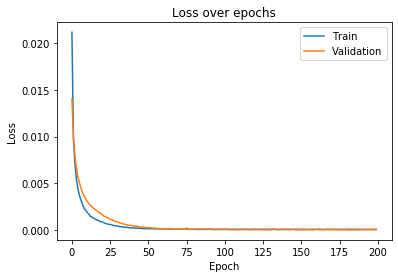

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_cases\assets
INFO:tensorflow:Assets written to: model_fatality\assets


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import time

NAME_confirm = "Covid-19-LSTM-confirm-{}".format(int(time.time()))
NAME_fatal = "Covid-19-LSTM-fatal-{}".format(int(time.time()))



#### Train the model ####
n_output_node = 1
input_shape=np.array(train_inputs).shape[-2:]

batch_size = 64
epochs = 200
lr = 0.001

def create_model(inputs, targets, val_inputs, val_targets, NAME):
    
    tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
    
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.05))
    model.add(LSTM(32))
    model.add(Dropout(0.05))
    model.add(Dense(n_output_node, activation='relu'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MSLE, metrics=[ tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError() ])

    history = model.fit(inputs, targets, \
              epochs=epochs, \
              batch_size=batch_size, \
              validation_data=(val_inputs, val_targets), callbacks = [tensorboard])

    scores = model.evaluate(inputs, targets)
    print("Model Accuracy: {}".format(scores))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
    return model

print('Tarining model for ConfirmedCases')
model_cases = create_model(train_inputs, train_targets_c, val_inputs, val_targets_c, NAME_confirm)
print('Tarining model for Fatalities')
model_fatality = create_model(train_inputs_f, train_targets_f, val_inputs_f, val_targets_f, NAME_fatal)

model_cases.save('model_cases')
model_fatality.save('model_fatality')

Train on 16163 samples, validate on 3951 samples
Epoch 1/200
16163/16163 [==============================] - 9s 550us/sample - loss: 0.0199 - mean_absolute_error: 0.2118 - mean_squared_error: 8.2204 - val_loss: 0.0122 - val_mean_absolute_error: 0.2280 - val_mean_squared_error: 14.0402
Epoch 2/200
16163/16163 [==============================] - 4s 263us/sample - loss: 0.0073 - mean_absolute_error: 0.1546 - mean_squared_error: 6.9035 - val_loss: 0.0093 - val_mean_absolute_error: 0.2042 - val_mean_squared_error: 13.1655
Epoch 3/200
16163/16163 [==============================] - 4s 258us/sample - loss: 0.0057 - mean_absolute_error: 0.1378 - mean_squared_error: 6.4439 - val_loss: 0.0079 - val_mean_absolute_error: 0.1957 - val_mean_squared_error: 12.5673
Epoch 4/200
16163/16163 [==============================] - 5s 292us/sample - loss: 0.0048 - mean_absolute_error: 0.1277 - mean_squared_error: 6.0498 - val_loss: 0.0070 - val_mean_absolute_error: 0.1827 - val_mean_squared_error: 12.0899
Epoch 5

Epoch 69/200
16163/16163 [==============================] - 4s 254us/sample - loss: 1.3936e-04 - mean_absolute_error: 0.0240 - mean_squared_error: 0.1267 - val_loss: 1.1657e-04 - val_mean_absolute_error: 0.0388 - val_mean_squared_error: 0.5835
Epoch 70/200
16163/16163 [==============================] - 4s 239us/sample - loss: 1.5261e-04 - mean_absolute_error: 0.0242 - mean_squared_error: 0.1283 - val_loss: 9.5297e-05 - val_mean_absolute_error: 0.0338 - val_mean_squared_error: 0.5582
Epoch 71/200
16163/16163 [==============================] - 4s 241us/sample - loss: 1.4278e-04 - mean_absolute_error: 0.0244 - mean_squared_error: 0.1553 - val_loss: 1.0056e-04 - val_mean_absolute_error: 0.0340 - val_mean_squared_error: 0.5299
Epoch 72/200
16163/16163 [==============================] - 4s 231us/sample - loss: 1.2953e-04 - mean_absolute_error: 0.0223 - mean_squared_error: 0.1307 - val_loss: 8.6371e-05 - val_mean_absolute_error: 0.0337 - val_mean_squared_error: 0.5047
Epoch 73/200
16163/16163

16163/16163 [==============================] - 4s 262us/sample - loss: 1.2248e-04 - mean_absolute_error: 0.0188 - mean_squared_error: 0.0340 - val_loss: 4.6869e-05 - val_mean_absolute_error: 0.0210 - val_mean_squared_error: 0.1394
Epoch 136/200
16163/16163 [==============================] - 4s 243us/sample - loss: 1.2268e-04 - mean_absolute_error: 0.0190 - mean_squared_error: 0.0440 - val_loss: 5.2328e-05 - val_mean_absolute_error: 0.0183 - val_mean_squared_error: 0.1316
Epoch 137/200
16163/16163 [==============================] - 4s 242us/sample - loss: 1.0347e-04 - mean_absolute_error: 0.0168 - mean_squared_error: 0.0326 - val_loss: 4.8382e-05 - val_mean_absolute_error: 0.0194 - val_mean_squared_error: 0.1239
Epoch 138/200
16163/16163 [==============================] - 4s 222us/sample - loss: 1.1842e-04 - mean_absolute_error: 0.0195 - mean_squared_error: 0.0438 - val_loss: 4.3325e-05 - val_mean_absolute_error: 0.0187 - val_mean_squared_error: 0.1283
Epoch 139/200
16163/16163 [=======

16163/16163 [==============================] - 4s 255us/sample - loss: 3.6954e-05 - mean_absolute_error: 0.0088 - mean_squared_error: 0.0103
Model Accuracy: [3.695417318516285e-05, 0.0087962365, 0.01029769]


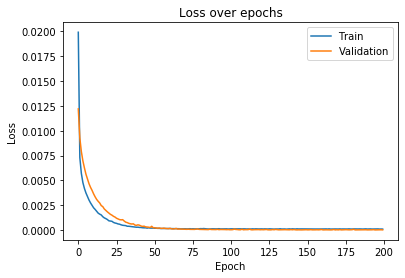

Train on 16163 samples, validate on 3951 samples
Epoch 1/200
16163/16163 [==============================] - 8s 505us/sample - loss: 0.1237 - mean_absolute_error: 0.3645 - mean_squared_error: 12.3211 - val_loss: 0.0161 - val_mean_absolute_error: 0.2694 - val_mean_squared_error: 15.1181
Epoch 2/200
16163/16163 [==============================] - 4s 224us/sample - loss: 0.0100 - mean_absolute_error: 0.2023 - mean_squared_error: 7.7966 - val_loss: 0.0096 - val_mean_absolute_error: 0.2275 - val_mean_squared_error: 13.1972
Epoch 3/200
16163/16163 [==============================] - 4s 220us/sample - loss: 0.0066 - mean_absolute_error: 0.1766 - mean_squared_error: 6.7469 - val_loss: 0.0075 - val_mean_absolute_error: 0.2082 - val_mean_squared_error: 12.2018
Epoch 4/200
16163/16163 [==============================] - 4s 227us/sample - loss: 0.0050 - mean_absolute_error: 0.1582 - mean_squared_error: 6.0574 - val_loss: 0.0063 - val_mean_absolute_error: 0.1982 - val_mean_squared_error: 11.4378
Epoch 

Epoch 69/200
16163/16163 [==============================] - 4s 246us/sample - loss: 1.2118e-04 - mean_absolute_error: 0.0246 - mean_squared_error: 0.1708 - val_loss: 9.8478e-05 - val_mean_absolute_error: 0.0339 - val_mean_squared_error: 0.5231
Epoch 70/200
16163/16163 [==============================] - 4s 244us/sample - loss: 1.1904e-04 - mean_absolute_error: 0.0250 - mean_squared_error: 0.1391 - val_loss: 1.1953e-04 - val_mean_absolute_error: 0.0379 - val_mean_squared_error: 0.5010
Epoch 71/200
16163/16163 [==============================] - 4s 269us/sample - loss: 1.1890e-04 - mean_absolute_error: 0.0248 - mean_squared_error: 0.1370 - val_loss: 9.2072e-05 - val_mean_absolute_error: 0.0334 - val_mean_squared_error: 0.48314 - mean_absolute_error: 0.0247 - mean_squared_error: 
Epoch 72/200
16163/16163 [==============================] - 5s 278us/sample - loss: 1.2590e-04 - mean_absolute_error: 0.0246 - mean_squared_error: 0.1287 - val_loss: 9.2784e-05 - val_mean_absolute_error: 0.0312 - v

16163/16163 [==============================] - 4s 269us/sample - loss: 9.5497e-05 - mean_absolute_error: 0.0209 - mean_squared_error: 0.0702 - val_loss: 3.8283e-05 - val_mean_absolute_error: 0.0147 - val_mean_squared_error: 0.0950
Epoch 136/200
16163/16163 [==============================] - 5s 286us/sample - loss: 1.0396e-04 - mean_absolute_error: 0.0205 - mean_squared_error: 0.0553 - val_loss: 4.9277e-05 - val_mean_absolute_error: 0.0172 - val_mean_squared_error: 0.1009
Epoch 137/200
16163/16163 [==============================] - 4s 235us/sample - loss: 9.7712e-05 - mean_absolute_error: 0.0200 - mean_squared_error: 0.0542 - val_loss: 4.1136e-05 - val_mean_absolute_error: 0.0171 - val_mean_squared_error: 0.1025
Epoch 138/200
16163/16163 [==============================] - 4s 237us/sample - loss: 9.4988e-05 - mean_absolute_error: 0.0200 - mean_squared_error: 0.0500 - val_loss: 5.8597e-05 - val_mean_absolute_error: 0.0187 - val_mean_squared_error: 0.0951
Epoch 139/200
16163/16163 [=======

16163/16163 [==============================] - 3s 211us/sample - loss: 2.3328e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 0.0072
Model Accuracy: [2.3327916460693974e-05, 0.006743292, 0.007163099]


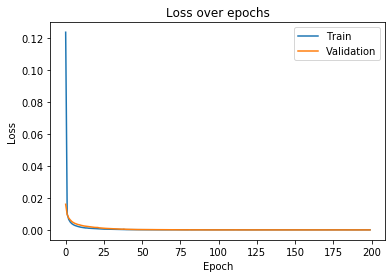

INFO:tensorflow:Assets written to: model_c_with_state\assets
INFO:tensorflow:Assets written to: model_f_with_state\assets


In [10]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import time

NAME_confirm = "Covid-19-LSTM-With-State-confirm{}".format(int(time.time()))
NAME_fatal = "Covid-19-LSTM-With-State-fatal{}".format(int(time.time()))



n_output_node = 1
input_shape=np.array(train_inputs).shape[-2:]
input_shape_geo=np.array(train_inputs_geo).shape

batch_size = 64
epochs = 200
lr = 0.001


def create_model(inputs, inputs_geo, targets, v_inputs, v_inputs_geo, v_targets, NAME):
    
    tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
    
    geo_input = Input(shape=(294,), name='input_geo')
    h_state = Dense(64, activation='relu')(geo_input)
    h_state = Dense(64, activation='relu')(h_state)
    c_state = Dense(64, activation='relu')(geo_input)
    c_state = Dense(64, activation='relu')(c_state)

    ts_input = Input(shape=input_shape, name='input_ts')
    lstm = LSTM(64, return_sequences=True)(ts_input, initial_state=[ h_state, c_state ])
    lstm = Dropout(0.05)(lstm)
    lstm = LSTM(32)(lstm)
    lstm = Dropout(0.05)(lstm)
    main_output = Dense(n_output_node, activation='relu', name='output_main')(lstm)
    
    model = Model(inputs=[ geo_input, ts_input ], outputs=main_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MSLE, metrics=[ tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError() ])
    
    history = model.fit([ inputs_geo, inputs ],  targets, \
              epochs=epochs, \
              batch_size=batch_size, \
              validation_data=({ 'input_geo': v_inputs_geo, 'input_ts': v_inputs },{ 'output_main': v_targets}) , callbacks = [tensorboard])

    scores = model.evaluate({ 'input_geo': inputs_geo, 'input_ts': inputs }, targets)
    print("Model Accuracy: {}".format(scores))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
    return model
                        
    

model_cases = create_model(np.array(train_inputs), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c), NAME_confirm)
model_fatality = create_model(np.array(train_inputs_f), np.array(train_inputs_geo), np.array(train_targets_f), np.array(val_inputs_f), np.array(val_inputs_geo), np.array(val_targets_f), NAME_fatal)

model_cases.save('model_c_with_state')
model_fatality.save('model_f_with_state')

In [11]:
model_cases = tf.keras.models.load_model('model_c_with_state')
model_fatality = tf.keras.models.load_model('model_f_with_state')

ValueError: Layer lstm_4 expects 1 inputs, but it received 3 input tensors. Inputs received: [<tf.Tensor 'input_ts_2:0' shape=(None, 7, 1) dtype=float32>, <tf.Tensor 'dense_3_1/Identity:0' shape=(None, 64) dtype=float32>, <tf.Tensor 'dense_5_1/Identity:0' shape=(None, 64) dtype=float32>]

In [12]:
def predict_cases(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['ConfirmedCases_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['ConfirmedCases']])
    
    predictions = model_cases.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['ConfirmedCases']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_c.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
    
    errorcases = (actuals - scaler_c.inverse_transform(np.array(predictions).reshape(-1,1)))/actuals
    errorcases =  abs(errorcases) * 100
    print ('Error :', errorcases, '%')
    
    
def predict_fatality(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['Fatalities_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['Fatalities']])
    
    predictions = model_fatality.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['Fatalities']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_f.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
    
    errorfatal = (actuals - scaler_f.inverse_transform(np.array(predictions).reshape(-1,1)))/actuals
    errorfatal =  abs(errorfatal) * 100
    print ('Error :', errorfatal, '%')
      

predict_cases('Malaysia', 'Unknown')
predict_cases('Korea, South', 'Unknown')
predict_cases('Italy', 'Unknown')

predict_fatality('Malaysia', 'Unknown')
predict_fatality('Korea, South', 'Unknown')
predict_fatality('Italy', 'Unknown')

D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Inputs: [6726, 6742, 6779, 6819, 6855, 6872, 6894], Pred: [[6884.29630583]], Expected: [6941]
Error : [[0.8169383975034403]] %
Inputs: [10936, 10962, 10991, 11018, 11037, 11050, 11065], Pred: [[11029.78795907]], Expected: [11078]
Error : [[0.43520528008133486]] %
Inputs: [219814, 221216, 222104, 223096, 223885, 224760, 225435], Pred: [[234200.1823531]], Expected: [225886]
Error : [[3.680698384625884]] %


D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/sta

Inputs: [109, 109, 111, 112, 112, 113, 113], Pred: [[111.01738109]], Expected: [113]
Error : [[1.754530009706459]] %
Inputs: [258, 259, 260, 260, 262, 262, 263], Pred: [[262.12236831]], Expected: [263]
Error : [[0.33370026254834284]] %
Inputs: [30739, 30911, 31106, 31368, 31610, 31763, 31908], Pred: [[32251.20523281]], Expected: [32007]
Error : [[0.7629744518729492]] %


D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [26]:
import time

test_df['ConfirmedCases'] = None
test_df['Fatalities'] = None
geo_df = None

tic = time.perf_counter()
temp_df = train_df

# For each test row
for i in range(len(test_df)):
    
    if i%1000 == 0:
        toc = time.perf_counter()
        print('Looping throught the index {} - {:.2f} sec(s) taken...'.format(i, (toc-tic)))
   
    current = test_df.iloc[i]         
    geo_df = temp_df[(temp_df.Country_Region == current.Country_Region) & (temp_df.Province_State == current.Province_State) & (temp_df.Day >= (current.Day - historical_steps)) & (temp_df.Day <= (current.Day))]
        
     # Find historical steps in train data
    if not geo_df.empty and geo_df.shape[0] >= 7:                 
        
        
        if geo_df.shape[0] == 8:
            input_geo = np.array(geo_df.iloc[-historical_steps-1][geo_columns]).astype(np.float32).reshape(1, len(geo_columns))
            pred = model_cases.predict([ input_geo, np.array(geo_df.iloc[-historical_steps-1:-1][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
            pred_f = model_fatality.predict([ input_geo, np.array(geo_df.iloc[-historical_steps-1:-1,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
        else:
            input_geo = np.array(geo_df.iloc[-historical_steps][geo_columns]).astype(np.float32).reshape(1, len(geo_columns))
            pred = model_cases.predict([ input_geo, np.array(geo_df.iloc[-historical_steps:,][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
            pred_f = model_fatality.predict([ input_geo, np.array(geo_df.iloc[-historical_steps:,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
              
        test_df.loc[i, 'ConfirmedCases_scaled'] = pred[0][0]
        test_df.loc[i, 'Fatalities_scaled'] = pred_f[0][0]
        
        # Save current data in train_df for next if empty
        if geo_df.iloc[-1:,].Day.values[0] != current.Day:  
            
            new_item = { 'ConfirmedCases_scaled': pred[0][0], 'Fatalities_scaled': pred_f[0][0], 'Day': current.Day, \
                         'Country_Region': current.Country_Region, 'Province_State': current.Province_State }
            
            for j in range(len(geo_columns)):
                new_item['Geo_' + str(j)] = 1 if geo_df.iloc[-1:,]['Geo_' + str(j)].values[0] == 1 else 0
            
            temp_df = temp_df.append(new_item, ignore_index=True)

test_df[['ConfirmedCases']] = scaler_c.inverse_transform(test_df[['ConfirmedCases_scaled']])
test_df[['Fatalities']] = scaler_f.inverse_transform(test_df[['Fatalities_scaled']]) 

Looping throught the index 0 - 0.00 sec(s) taken...


D:\Anaconda3\lib\site-packages\pandas\core\series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Looping throught the index 1000 - 99.01 sec(s) taken...
Looping throught the index 2000 - 205.71 sec(s) taken...
Looping throught the index 3000 - 309.68 sec(s) taken...
Looping throught the index 4000 - 413.40 sec(s) taken...
Looping throught the index 5000 - 510.10 sec(s) taken...
Looping throught the index 6000 - 607.69 sec(s) taken...
Looping throught the index 7000 - 715.59 sec(s) taken...
Looping throught the index 8000 - 819.02 sec(s) taken...
Looping throught the index 9000 - 921.69 sec(s) taken...
Looping throught the index 10000 - 1021.68 sec(s) taken...
Looping throught the index 11000 - 1122.13 sec(s) taken...
Looping throught the index 12000 - 1220.96 sec(s) taken...
Looping throught the index 13000 - 1320.93 sec(s) taken...
Looping throught the index 14000 - 1424.18 sec(s) taken...
Looping throught the index 15000 - 1519.45 sec(s) taken...
Looping throught the index 16000 - 1615.34 sec(s) taken...
Looping throught the index 17000 - 1711.97 sec(s) taken...
Looping throught

In [27]:
test_df[(test_df.Country_Region=='Malaysia') & (test_df.Province_State=='Unknown')].iloc[-35:,:]
# temp_df[(temp_df.Country_Region=='Australia') & (temp_df.Province_State=='New South Wales')].iloc[-35:,:]

,Country_Region,Province_State,Date,ForecastId,Date_dt,Day,ConfirmedCases,Fatalities,ConfirmedCases_scaled,Fatalities_scaled
18609,Malaysia,Unknown,2020-04-14,18610,2020-04-14,83,4974.452973,77.458705,0.329804,0.085735
18610,Malaysia,Unknown,2020-04-15,18611,2020-04-15,84,5148.143951,82.997348,0.341319,0.091865
18611,Malaysia,Unknown,2020-04-16,18612,2020-04-16,85,5220.178508,83.799991,0.346095,0.092753
18612,Malaysia,Unknown,2020-04-17,18613,2020-04-17,86,5308.379722,84.047275,0.351943,0.093027
18613,Malaysia,Unknown,2020-04-18,18614,2020-04-18,87,5352.680811,85.654223,0.354880,0.094806
18614,Malaysia,Unknown,2020-04-19,18615,2020-04-19,88,5379.559759,87.554551,0.356662,0.096909
18615,Malaysia,Unknown,2020-04-20,18616,2020-04-20,89,5447.665142,88.302689,0.361177,0.097737
18616,Malaysia,Unknown,2020-04-21,18617,2020-04-21,90,5470.576709,87.671394,0.362696,0.097039
18617,Malaysia,Unknown,2020-04-22,18618,2020-04-22,91,5517.033651,90.954771,0.365776,0.100673
18618,Malaysia,Unknown,2020-04-23,18619,2020-04-23,92,5560.940069,92.077739,0.368687,0.101916


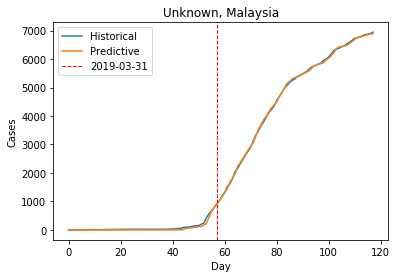

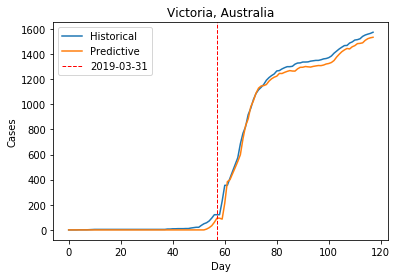

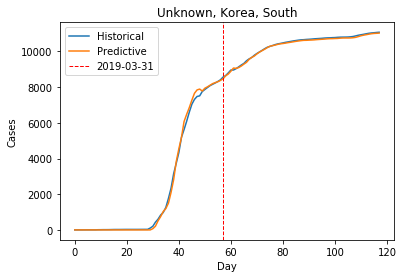

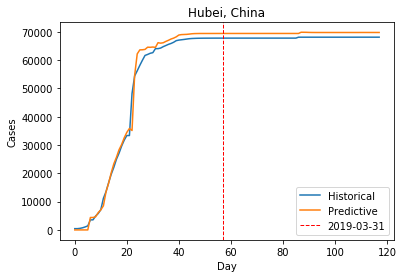

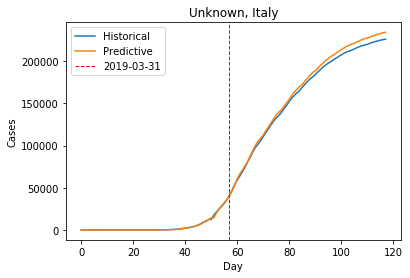

[None, None, None, None, None]

In [28]:
def plot_by_country(country, state):

    from_day_predicting = 57
    hist_df = train_df[(train_df.Country_Region == country) & (train_df.Province_State == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'sum'}).reset_index()
    pred_df = test_df[(test_df.Country_Region == country) & (test_df.Province_State == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'sum'}).reset_index()

    plt.title('{}, {}'.format(state, country))
    plt.plot(hist_df.Day, hist_df.ConfirmedCases, label='Historical')
    plt.plot(pred_df.Day, pred_df.ConfirmedCases, label='Predictive')
    plt.axvline(x=57, color='r', linestyle='--', linewidth=1, label='2019-03-31')
    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()
    
[ plot_by_country(country, state) for country, state in [ \
    ('Malaysia', 'Unknown'), ('Australia', 'Victoria'), ('Korea, South', 'Unknown'), ('China', 'Hubei'), ('Italy', 'Unknown')]]